In [1]:
%load_ext autoreload

In [2]:
%reload_ext autoreload

In [3]:
### Pytorch single dense layer neural network
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


from torch.utils.data import DataLoader, TensorDataset

from constants import chord_majmin_map
from utils import convert_label_to_idx, evaluate, evaluate_by_chord, get_chord_error

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Read data and convert to tensor

In [4]:
# Read csv dataset and convert to tensor
X_train = pd.read_csv('data/X_train.csv', header=None)
y_train = pd.read_csv('data/y_train.csv', header=None)
X_test = pd.read_csv('data/X_test.csv', header=None)
y_test = pd.read_csv('data/y_test.csv', header=None)

In [5]:
y_train_idx = y_train.apply(lambda x: convert_label_to_idx(*x), axis=1)  
y_test_idx = y_test.apply(lambda x: convert_label_to_idx(*x), axis=1)

In [6]:
# Scale input data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train_idx.values, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test_idx.values, dtype=torch.long)

### Setup data loader

In [8]:
# Add data to dataloader
training_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Train Single layer Dense Network

### Define NN

In [9]:
# Implement single dense layer neural network
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden_layer = nn.Linear(12, 32)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(32, 24)


    def forward(self, x):
        x = self.activation(self.hidden_layer(x))
        return self.output_layer(x)

### Training and validation

In [10]:
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

num_epochs = 100
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Loop over epochs
for epoch in tqdm(range(num_epochs)):
    epoch_train_loss = []
    epoch_train_acc = []
    epoch_test_loss = []
    epoch_test_acc = []
    
    # Training
    model.train()
    for local_batch, local_labels in train_dataloader:

        X_batch, y_batch = local_batch.to(device), local_labels.to(device)

        # forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()

        # compute train metrics
        acc = (torch.argmax(y_pred, 1) == y_batch).float().mean()
        epoch_train_loss.append(float(loss))
        epoch_train_acc.append(float(acc))

    # Aggregate batch metrics
    train_losses.append(np.mean(epoch_train_loss))
    train_accs.append(np.mean(epoch_train_acc))
    print(f"Epoch {epoch} - Train loss: {train_losses[-1]} - Train acc: {train_accs[-1]}")

    # Validation
    model.eval()
    for local_batch, local_labels in test_dataloader:
        X_batch, y_batch = local_batch.to(device), local_labels.to(device)

        y_pred = model(X_batch)
        cross_entropy_loss = criterion(y_pred, y_batch)

        # compute test metrics
        acc = (torch.argmax(y_pred, 1) == y_batch).float().mean()
        epoch_test_loss.append(float(cross_entropy_loss))
        epoch_test_acc.append(float(acc))

    # Aggregate batch metrics  
    test_losses.append(np.mean(epoch_test_loss))
    test_accs.append(np.mean(epoch_test_acc))
    print(f"Epoch {epoch} - Test loss: {test_losses[-1]} - Test acc: {test_accs[-1]}")


  1%|          | 1/100 [00:00<00:39,  2.52it/s]

Epoch 0 - Train loss: 2.393398740366435 - Train acc: 0.42519151723438314
Epoch 0 - Test loss: 1.626157539053113 - Test acc: 0.6373633043304163


  2%|▏         | 2/100 [00:00<00:37,  2.63it/s]

Epoch 1 - Train loss: 1.2896396739600484 - Train acc: 0.6703958022220252
Epoch 1 - Test loss: 1.0768134322466028 - Test acc: 0.7065001688702568


  3%|▎         | 3/100 [00:01<00:37,  2.59it/s]

Epoch 2 - Train loss: 0.9974314867113738 - Train acc: 0.7393380979518719
Epoch 2 - Test loss: 0.93366174236018 - Test acc: 0.7615953808679631


  4%|▍         | 4/100 [00:01<00:37,  2.57it/s]

Epoch 3 - Train loss: 0.9087543506258806 - Train acc: 0.769307424001095
Epoch 3 - Test loss: 0.8800226811963227 - Test acc: 0.780817218475941


  5%|▌         | 5/100 [00:01<00:36,  2.59it/s]

Epoch 4 - Train loss: 0.867934047841705 - Train acc: 0.7834104073689123
Epoch 4 - Test loss: 0.8533343849069785 - Test acc: 0.787274636835328


  6%|▌         | 6/100 [00:02<00:36,  2.56it/s]

Epoch 5 - Train loss: 0.8460868637791663 - Train acc: 0.7902575361087183
Epoch 5 - Test loss: 0.8357165212406538 - Test acc: 0.7880029765723263


  7%|▋         | 7/100 [00:02<00:35,  2.61it/s]

Epoch 6 - Train loss: 0.8322564611386826 - Train acc: 0.7935818385650224
Epoch 6 - Test loss: 0.8241459224860705 - Test acc: 0.7899056323535779


  8%|▊         | 8/100 [00:03<00:35,  2.62it/s]

Epoch 7 - Train loss: 0.8220203750069366 - Train acc: 0.7973654708520179
Epoch 7 - Test loss: 0.8138229828230373 - Test acc: 0.7941516425597106


  9%|▉         | 9/100 [00:03<00:36,  2.47it/s]

Epoch 8 - Train loss: 0.8136260450019964 - Train acc: 0.7998139325011472
Epoch 8 - Test loss: 0.8088849784504056 - Test acc: 0.7973394484420098


 10%|█         | 10/100 [00:03<00:36,  2.48it/s]

Epoch 9 - Train loss: 0.8072523199389333 - Train acc: 0.80082990783747
Epoch 9 - Test loss: 0.8028522615969493 - Test acc: 0.795603044370082


 11%|█         | 11/100 [00:04<00:35,  2.52it/s]

Epoch 10 - Train loss: 0.8015143623400162 - Train acc: 0.7999696374741371
Epoch 10 - Test loss: 0.7980660421686022 - Test acc: 0.7970861130984042


 12%|█▏        | 12/100 [00:04<00:34,  2.58it/s]

Epoch 11 - Train loss: 0.7971839322102978 - Train acc: 0.8018303125963083
Epoch 11 - Test loss: 0.7945579251381739 - Test acc: 0.7970861130984042


 13%|█▎        | 13/100 [00:05<00:34,  2.55it/s]

Epoch 12 - Train loss: 0.7919307955177376 - Train acc: 0.8021767563082177
Epoch 12 - Test loss: 0.7900782598874956 - Test acc: 0.7989729352646473


 14%|█▍        | 14/100 [00:05<00:33,  2.54it/s]

Epoch 13 - Train loss: 0.7881970256567001 - Train acc: 0.8032394432433517
Epoch 13 - Test loss: 0.7866450123761961 - Test acc: 0.8000311392764147


 15%|█▌        | 15/100 [00:05<00:33,  2.55it/s]

Epoch 14 - Train loss: 0.7851118087233984 - Train acc: 0.8031615906232141
Epoch 14 - Test loss: 0.7829590954705683 - Test acc: 0.8015062911972326


 16%|█▌        | 16/100 [00:06<00:34,  2.42it/s]

Epoch 15 - Train loss: 0.7813508021457313 - Train acc: 0.8039089748677651
Epoch 15 - Test loss: 0.7788574026205153 - Test acc: 0.8031424168516829


 17%|█▋        | 17/100 [00:06<00:33,  2.48it/s]

Epoch 16 - Train loss: 0.7779409418325253 - Train acc: 0.8038505854360726
Epoch 16 - Test loss: 0.7754113716292755 - Test acc: 0.8020815740081029


 18%|█▊        | 18/100 [00:07<00:32,  2.49it/s]

Epoch 17 - Train loss: 0.7745639833500567 - Train acc: 0.8030564897263531
Epoch 17 - Test loss: 0.7745725913509649 - Test acc: 0.8022504645492394


 19%|█▉        | 19/100 [00:07<00:32,  2.50it/s]

Epoch 18 - Train loss: 0.7714309599501135 - Train acc: 0.8056100522723433
Epoch 18 - Test loss: 0.7711017983746155 - Test acc: 0.8031318612123659


 20%|██        | 20/100 [00:07<00:32,  2.43it/s]

Epoch 19 - Train loss: 0.7688643447219523 - Train acc: 0.804617432735426
Epoch 19 - Test loss: 0.7688468097080111 - Test acc: 0.8029814431180504


 21%|██        | 21/100 [00:08<00:36,  2.14it/s]

Epoch 20 - Train loss: 0.7662358432339981 - Train acc: 0.805547770363333
Epoch 20 - Test loss: 0.7665916469084655 - Test acc: 0.8026515791553477


 22%|██▏       | 22/100 [00:09<00:39,  1.97it/s]

Epoch 21 - Train loss: 0.7640356732858136 - Train acc: 0.8055438776187298
Epoch 21 - Test loss: 0.7639169454262519 - Test acc: 0.8040449247934431


 23%|██▎       | 23/100 [00:09<00:40,  1.91it/s]

Epoch 22 - Train loss: 0.7614507848238197 - Train acc: 0.8058202540660653
Epoch 22 - Test loss: 0.7622770273872695 - Test acc: 0.8038971458430065


 24%|██▍       | 24/100 [00:10<00:41,  1.85it/s]

Epoch 23 - Train loss: 0.7585170893792079 - Train acc: 0.8072215993575451
Epoch 23 - Test loss: 0.7594942420877088 - Test acc: 0.8037097828550489


 25%|██▌       | 25/100 [00:10<00:43,  1.72it/s]

Epoch 24 - Train loss: 0.7559176819741459 - Train acc: 0.8067311285055272
Epoch 24 - Test loss: 0.7575224221376848 - Test acc: 0.8023956046678633


 26%|██▌       | 26/100 [00:11<00:43,  1.70it/s]

Epoch 25 - Train loss: 0.7539558816250129 - Train acc: 0.8062328724315883
Epoch 25 - Test loss: 0.7558717612196638 - Test acc: 0.8041293699079783


 27%|██▋       | 27/100 [00:12<00:41,  1.74it/s]

Epoch 26 - Train loss: 0.7518685027088285 - Train acc: 0.8066493834080718
Epoch 26 - Test loss: 0.7541244835129584 - Test acc: 0.8037889503059586


 28%|██▊       | 28/100 [00:12<00:40,  1.77it/s]

Epoch 27 - Train loss: 0.7496649635613232 - Train acc: 0.8062289798206278
Epoch 27 - Test loss: 0.7528086201682764 - Test acc: 0.8038786733961855


 29%|██▉       | 29/100 [00:13<00:39,  1.79it/s]

Epoch 28 - Train loss: 0.7471841890448412 - Train acc: 0.8069335450773282
Epoch 28 - Test loss: 0.7488603022398125 - Test acc: 0.8041979817195712


 30%|███       | 30/100 [00:13<00:39,  1.77it/s]

Epoch 29 - Train loss: 0.7452954532319654 - Train acc: 0.8070347533632287
Epoch 29 - Test loss: 0.7478800103926534 - Test acc: 0.8051875739197456


 31%|███       | 31/100 [00:14<00:49,  1.39it/s]

Epoch 30 - Train loss: 0.7431157965029301 - Train acc: 0.8072215993575451
Epoch 30 - Test loss: 0.7470841772893336 - Test acc: 0.8036411713555222


 32%|███▏      | 32/100 [00:15<00:46,  1.46it/s]

Epoch 31 - Train loss: 0.7416241893987484 - Train acc: 0.8072838814001981
Epoch 31 - Test loss: 0.7457315798517297 - Test acc: 0.8042085373588882


 33%|███▎      | 33/100 [00:16<00:43,  1.53it/s]

Epoch 32 - Train loss: 0.739498506145627 - Train acc: 0.8072838814001981
Epoch 32 - Test loss: 0.7437906803572989 - Test acc: 0.8038786733961855


 34%|███▍      | 34/100 [00:16<00:41,  1.60it/s]

Epoch 33 - Train loss: 0.7376444700587491 - Train acc: 0.8082103264171446
Epoch 33 - Test loss: 0.7436683307455473 - Test acc: 0.8054145203210921


 35%|███▌      | 35/100 [00:17<00:39,  1.65it/s]

Epoch 34 - Train loss: 0.735872521796034 - Train acc: 0.8085723405728961
Epoch 34 - Test loss: 0.7400481151660699 - Test acc: 0.8047811813379457


 36%|███▌      | 36/100 [00:17<00:37,  1.70it/s]

Epoch 35 - Train loss: 0.7339495323899081 - Train acc: 0.8090667040358744
Epoch 35 - Test loss: 0.7391502772950377 - Test acc: 0.8047811813379457


 37%|███▋      | 37/100 [00:18<00:36,  1.71it/s]

Epoch 36 - Train loss: 0.7319719457973813 - Train acc: 0.8096311347634269
Epoch 36 - Test loss: 0.737842756416161 - Test acc: 0.8068368940453254


 38%|███▊      | 38/100 [00:18<00:35,  1.74it/s]

Epoch 37 - Train loss: 0.7299775532008287 - Train acc: 0.8096155643195849
Epoch 37 - Test loss: 0.7377759102751448 - Test acc: 0.8065017521069312


 39%|███▉      | 39/100 [00:19<00:34,  1.77it/s]

Epoch 38 - Train loss: 0.7287248765941158 - Train acc: 0.8088720726859944
Epoch 38 - Test loss: 0.7350073768830424 - Test acc: 0.8065624471110199


 40%|████      | 40/100 [00:19<00:33,  1.79it/s]

Epoch 39 - Train loss: 0.7272330120940914 - Train acc: 0.8101332834483262
Epoch 39 - Test loss: 0.7350797770223069 - Test acc: 0.8076496792089253


 41%|████      | 41/100 [00:20<00:32,  1.81it/s]

Epoch 40 - Train loss: 0.7256436444852384 - Train acc: 0.8091212008566065
Epoch 40 - Test loss: 0.7332930691267183 - Test acc: 0.8066600870087509


 42%|████▏     | 42/100 [00:21<00:31,  1.81it/s]

Epoch 41 - Train loss: 0.7238861755405306 - Train acc: 0.8106276470449473
Epoch 41 - Test loss: 0.7318459287363821 - Test acc: 0.8061692493124158


 43%|████▎     | 43/100 [00:21<00:33,  1.69it/s]

Epoch 42 - Train loss: 0.7225171732528327 - Train acc: 0.8109779833678172
Epoch 42 - Test loss: 0.731351447979193 - Test acc: 0.8072300921559958


 44%|████▍     | 44/100 [00:22<00:32,  1.72it/s]

Epoch 43 - Train loss: 0.7209458682569153 - Train acc: 0.8107794594069767
Epoch 43 - Test loss: 0.730563690681108 - Test acc: 0.8064305014635256


 45%|████▌     | 45/100 [00:22<00:31,  1.75it/s]

Epoch 44 - Train loss: 0.7202176807840843 - Train acc: 0.8109001307476796
Epoch 44 - Test loss: 0.728926458751968 - Test acc: 0.8055992441651709


 46%|████▌     | 46/100 [00:23<00:30,  1.75it/s]

Epoch 45 - Train loss: 0.7183610432083831 - Train acc: 0.8107483183856502
Epoch 45 - Test loss: 0.7271258111711572 - Test acc: 0.8073171761023437


 47%|████▋     | 47/100 [00:23<00:30,  1.75it/s]

Epoch 46 - Train loss: 0.7169596865572737 - Train acc: 0.8118966430292002
Epoch 46 - Test loss: 0.727487161209446 - Test acc: 0.8069081446887311


 48%|████▊     | 48/100 [00:24<00:29,  1.76it/s]

Epoch 47 - Train loss: 0.7154033099188398 - Train acc: 0.8111375809517677
Epoch 47 - Test loss: 0.72542285997206 - Test acc: 0.8066706426480678


 49%|████▉     | 49/100 [00:25<00:28,  1.77it/s]

Epoch 48 - Train loss: 0.7140537024613454 - Train acc: 0.8120367775583481
Epoch 48 - Test loss: 0.7253298235189228 - Test acc: 0.8069055058569184


 50%|█████     | 50/100 [00:25<00:27,  1.79it/s]

Epoch 49 - Train loss: 0.712627662270593 - Train acc: 0.8112582524261133
Epoch 49 - Test loss: 0.7234253527606345 - Test acc: 0.8080639882861632


 51%|█████     | 51/100 [00:26<00:27,  1.78it/s]

Epoch 50 - Train loss: 0.7111803386109827 - Train acc: 0.8124688589786735
Epoch 50 - Test loss: 0.7232746633247555 - Test acc: 0.8073884267457493


 52%|█████▏    | 52/100 [00:26<00:26,  1.80it/s]

Epoch 51 - Train loss: 0.7099839638033255 - Train acc: 0.8128581215447909
Epoch 51 - Test loss: 0.7219303453155838 - Test acc: 0.8082144063804786


 53%|█████▎    | 53/100 [00:27<00:25,  1.81it/s]

Epoch 52 - Train loss: 0.7096098561858917 - Train acc: 0.8123404022824069
Epoch 52 - Test loss: 0.7211817760430081 - Test acc: 0.8079821820034406


 54%|█████▍    | 54/100 [00:27<00:25,  1.83it/s]

Epoch 53 - Train loss: 0.70810278114182 - Train acc: 0.8131033569707998
Epoch 53 - Test loss: 0.7211602297440873 - Test acc: 0.8091960817731488


 55%|█████▌    | 55/100 [00:28<00:24,  1.84it/s]

Epoch 54 - Train loss: 0.7068912853975468 - Train acc: 0.8116786560135572
Epoch 54 - Test loss: 0.718089159870647 - Test acc: 0.8076470400650464


 56%|█████▌    | 56/100 [00:28<00:23,  1.84it/s]

Epoch 55 - Train loss: 0.7057664522675655 - Train acc: 0.8127491280369694
Epoch 55 - Test loss: 0.7176218978397509 - Test acc: 0.809029830375891


 57%|█████▋    | 57/100 [00:29<00:23,  1.85it/s]

Epoch 56 - Train loss: 0.704278556287556 - Train acc: 0.8132979883206799
Epoch 56 - Test loss: 0.7164552793764943 - Test acc: 0.8086207989622786


 58%|█████▊    | 58/100 [00:29<00:22,  1.85it/s]

Epoch 57 - Train loss: 0.7036376209937938 - Train acc: 0.8126167787297425
Epoch 57 - Test loss: 0.7155408846770281 - Test acc: 0.808710521740439


 59%|█████▉    | 59/100 [00:30<00:22,  1.85it/s]

Epoch 58 - Train loss: 0.7032422835650466 - Train acc: 0.8139441641456878
Epoch 58 - Test loss: 0.7149955904920687 - Test acc: 0.8087949671670405


 60%|██████    | 60/100 [00:31<00:21,  1.86it/s]

Epoch 59 - Train loss: 0.7008099958901982 - Train acc: 0.8132045652567004
Epoch 59 - Test loss: 0.7152819020273797 - Test acc: 0.8086260766259039


 61%|██████    | 61/100 [00:31<00:20,  1.86it/s]

Epoch 60 - Train loss: 0.7003924647521546 - Train acc: 0.813535438524768
Epoch 60 - Test loss: 0.7138460247304427 - Test acc: 0.8088714954740714


 62%|██████▏   | 62/100 [00:32<00:21,  1.81it/s]

Epoch 61 - Train loss: 0.6995919940851194 - Train acc: 0.8138546338263114
Epoch 61 - Test loss: 0.7132968529668778 - Test acc: 0.8091908037974572


 63%|██████▎   | 63/100 [00:32<00:20,  1.80it/s]

Epoch 62 - Train loss: 0.6979737782959446 - Train acc: 0.8141777217388153
Epoch 62 - Test loss: 0.7117703536730162 - Test acc: 0.8087078829086264


 64%|██████▍   | 64/100 [00:33<00:19,  1.82it/s]

Epoch 63 - Train loss: 0.6981478151385025 - Train acc: 0.8130761085604339
Epoch 63 - Test loss: 0.7114517368883363 - Test acc: 0.811410129070282


 65%|██████▌   | 65/100 [00:33<00:19,  1.83it/s]

Epoch 64 - Train loss: 0.6952787981172314 - Train acc: 0.8149757100594952
Epoch 64 - Test loss: 0.711427990210618 - Test acc: 0.8088583010029419


 66%|██████▌   | 66/100 [00:34<00:18,  1.84it/s]

Epoch 65 - Train loss: 0.6949084338986821 - Train acc: 0.8142633594472312
Epoch 65 - Test loss: 0.7106638603809616 - Test acc: 0.809676363830167


 67%|██████▋   | 67/100 [00:34<00:17,  1.84it/s]

Epoch 66 - Train loss: 0.6943881038593069 - Train acc: 0.8142594668362707
Epoch 66 - Test loss: 0.7087424548820676 - Test acc: 0.8113177671482426


 68%|██████▊   | 68/100 [00:35<00:17,  1.86it/s]

Epoch 67 - Train loss: 0.6941726670136901 - Train acc: 0.8153649726256127
Epoch 67 - Test loss: 0.7083629647474639 - Test acc: 0.8112465165048369


 69%|██████▉   | 69/100 [00:35<00:16,  1.86it/s]

Epoch 68 - Train loss: 0.6926393170126885 - Train acc: 0.8148745017735948
Epoch 68 - Test loss: 0.7076490750799629 - Test acc: 0.8106501224153329


 70%|███████   | 70/100 [00:36<00:16,  1.83it/s]

Epoch 69 - Train loss: 0.691188827424306 - Train acc: 0.8158165172343831
Epoch 69 - Test loss: 0.706771084307376 - Test acc: 0.8119036059104959


 71%|███████   | 71/100 [00:37<00:15,  1.84it/s]

Epoch 70 - Train loss: 0.6906286307648158 - Train acc: 0.8146020179372198
Epoch 70 - Test loss: 0.7081927129735497 - Test acc: 0.8101751183340062


 72%|███████▏  | 72/100 [00:37<00:15,  1.85it/s]

Epoch 71 - Train loss: 0.6894433000563506 - Train acc: 0.8162330282108666
Epoch 71 - Test loss: 0.7080826185136565 - Test acc: 0.8111515157509849


 73%|███████▎  | 73/100 [00:38<00:14,  1.85it/s]

Epoch 72 - Train loss: 0.6891221766915556 - Train acc: 0.8151275224215246
Epoch 72 - Test loss: 0.7053861653929605 - Test acc: 0.8114945744968833


 74%|███████▍  | 74/100 [00:38<00:14,  1.83it/s]

Epoch 73 - Train loss: 0.6876843473435518 - Train acc: 0.8160578600494316
Epoch 73 - Test loss: 0.7054101879372022 - Test acc: 0.8130515327004237


 75%|███████▌  | 75/100 [00:39<00:13,  1.84it/s]

Epoch 74 - Train loss: 0.686581217387332 - Train acc: 0.8151236298105642
Epoch 74 - Test loss: 0.7038123754306613 - Test acc: 0.8124868055288704


 76%|███████▌  | 76/100 [00:39<00:13,  1.85it/s]

Epoch 75 - Train loss: 0.6866225970432898 - Train acc: 0.816517189880123
Epoch 75 - Test loss: 0.7030535529109196 - Test acc: 0.812056662836624


 77%|███████▋  | 77/100 [00:40<00:12,  1.85it/s]

Epoch 76 - Train loss: 0.6855956204402607 - Train acc: 0.8162291354662634
Epoch 76 - Test loss: 0.7030475397072538 - Test acc: 0.8122915260454747


 78%|███████▊  | 78/100 [00:40<00:11,  1.86it/s]

Epoch 77 - Train loss: 0.6847939680376395 - Train acc: 0.8162563838766295
Epoch 77 - Test loss: 0.7026104139095826 - Test acc: 0.8112359608655201


 79%|███████▉  | 79/100 [00:41<00:11,  1.86it/s]

Epoch 78 - Train loss: 0.6841131449413941 - Train acc: 0.8163030954754406
Epoch 78 - Test loss: 0.7018452828155138 - Test acc: 0.8127955582129394


 80%|████████  | 80/100 [00:41<00:10,  1.86it/s]

Epoch 79 - Train loss: 0.6832841993581019 - Train acc: 0.8164004110167379
Epoch 79 - Test loss: 0.7008720656652101 - Test acc: 0.8131095888726998


 81%|████████  | 81/100 [00:42<00:10,  1.87it/s]

Epoch 80 - Train loss: 0.6821855765019832 - Train acc: 0.8162330282108666
Epoch 80 - Test loss: 0.6999384100836609 - Test acc: 0.8131201445120168


 82%|████████▏ | 82/100 [00:42<00:09,  1.87it/s]

Epoch 81 - Train loss: 0.6815363371853337 - Train acc: 0.8160578600494316
Epoch 81 - Test loss: 0.6995875134830075 - Test acc: 0.8124472218034156


 83%|████████▎ | 83/100 [00:43<00:09,  1.88it/s]

Epoch 82 - Train loss: 0.6806966502703893 - Train acc: 0.8165755791781729
Epoch 82 - Test loss: 0.7005137916634844 - Test acc: 0.8126293068156817


 84%|████████▍ | 84/100 [00:44<00:08,  1.88it/s]

Epoch 83 - Train loss: 0.6798806304087018 - Train acc: 0.8176382661133069
Epoch 83 - Test loss: 0.6996684320934156 - Test acc: 0.8141044587364996


 85%|████████▌ | 85/100 [00:44<00:07,  1.88it/s]

Epoch 84 - Train loss: 0.6794630676641592 - Train acc: 0.8158710139214725
Epoch 84 - Test loss: 0.6977259610335864 - Test acc: 0.8135265367817505


 86%|████████▌ | 86/100 [00:45<00:07,  1.86it/s]

Epoch 85 - Train loss: 0.6782816605717612 - Train acc: 0.8169181302791219
Epoch 85 - Test loss: 0.6987866259994308 - Test acc: 0.8118033271809523


 87%|████████▋ | 87/100 [00:46<00:08,  1.47it/s]

Epoch 86 - Train loss: 0.6774728899579412 - Train acc: 0.817042694364428
Epoch 86 - Test loss: 0.6978566877504918 - Test acc: 0.8118033271809523


 88%|████████▊ | 88/100 [00:46<00:08,  1.48it/s]

Epoch 87 - Train loss: 0.6774656395072894 - Train acc: 0.8175720914596935
Epoch 87 - Test loss: 0.6960595499782662 - Test acc: 0.8125501393647718


 89%|████████▉ | 89/100 [00:47<00:07,  1.48it/s]

Epoch 88 - Train loss: 0.6766764195510625 - Train acc: 0.8178951793721974
Epoch 88 - Test loss: 0.6954224257881104 - Test acc: 0.812798197044752


 90%|█████████ | 90/100 [00:48<00:06,  1.45it/s]

Epoch 89 - Train loss: 0.675888595025101 - Train acc: 0.8170582648082699
Epoch 89 - Test loss: 0.6955075881868132 - Test acc: 0.8132098672901773


 91%|█████████ | 91/100 [00:48<00:06,  1.42it/s]

Epoch 90 - Train loss: 0.6752195119724146 - Train acc: 0.8181520926310877
Epoch 90 - Test loss: 0.6979287830010759 - Test acc: 0.8120698573077536


 92%|█████████▏| 92/100 [00:49<00:05,  1.48it/s]

Epoch 91 - Train loss: 0.6747500339832007 - Train acc: 0.8186659192825112
Epoch 91 - Test loss: 0.6956410342486117 - Test acc: 0.8137745947737969


 93%|█████████▎| 93/100 [00:50<00:04,  1.48it/s]

Epoch 92 - Train loss: 0.6742555061396996 - Train acc: 0.8180898107220774
Epoch 92 - Test loss: 0.6931414807030044 - Test acc: 0.8141836261874094


 94%|█████████▍| 94/100 [00:50<00:03,  1.50it/s]

Epoch 93 - Train loss: 0.6734984309283073 - Train acc: 0.8178796089283554
Epoch 93 - Test loss: 0.6947000621188998 - Test acc: 0.814033208093094


 95%|█████████▌| 95/100 [00:51<00:03,  1.56it/s]

Epoch 94 - Train loss: 0.6731563655517561 - Train acc: 0.8181754484304933
Epoch 94 - Test loss: 0.6932910496651814 - Test acc: 0.8143419607771629


 96%|█████████▌| 96/100 [00:51<00:02,  1.63it/s]

Epoch 95 - Train loss: 0.672066848307447 - Train acc: 0.8176343735023465
Epoch 95 - Test loss: 0.6927410730828789 - Test acc: 0.812798197044752


 97%|█████████▋| 97/100 [00:52<00:01,  1.69it/s]

Epoch 96 - Train loss: 0.671749694064059 - Train acc: 0.8190707524261133
Epoch 96 - Test loss: 0.6919278207561732 - Test acc: 0.8134552861383448


 98%|█████████▊| 98/100 [00:53<00:01,  1.73it/s]

Epoch 97 - Train loss: 0.670640099075343 - Train acc: 0.8186542414496297
Epoch 97 - Test loss: 0.6916777959668824 - Test acc: 0.8137666779662927


 99%|█████████▉| 99/100 [00:53<00:00,  1.76it/s]

Epoch 98 - Train loss: 0.6700179188641732 - Train acc: 0.8177861858643758
Epoch 98 - Test loss: 0.692470319296053 - Test acc: 0.812972365249514


100%|██████████| 100/100 [00:54<00:00,  1.85it/s]

Epoch 99 - Train loss: 0.6702451017004492 - Train acc: 0.8196157199652205
Epoch 99 - Test loss: 0.6917882614734909 - Test acc: 0.8133629242163054


## Plot training and test loss and accuracy by epoch

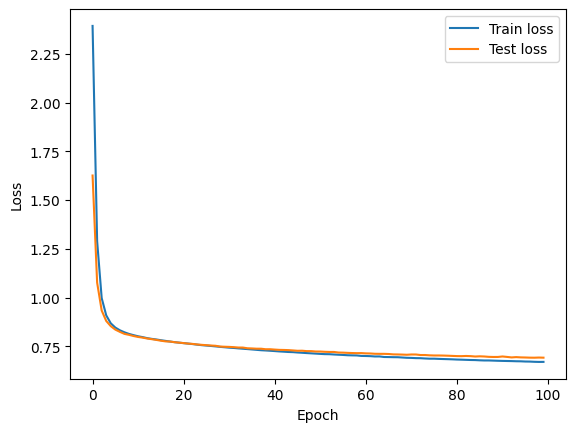

In [11]:
# Plot accuracy and loss
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

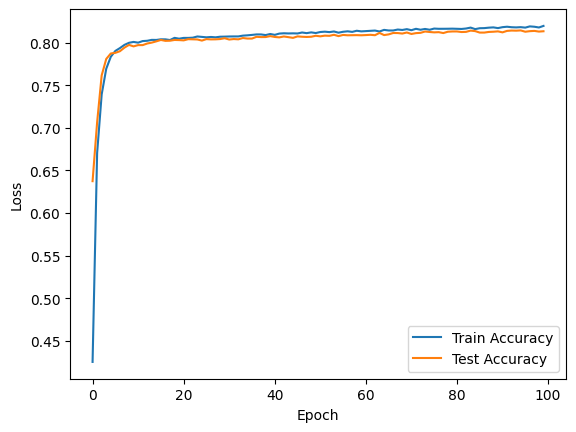

In [12]:
# Plot accuracy and loss
plt.figure()
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [13]:
# save model
torch.save(model.state_dict(), 'models/mlp_trained.pkl')

## Investigate model predictions
- Which chords are we good at predicting?
- Which chords do we often mistake for other chords? 

In [14]:
# Predict on test set
model.eval()
y_pred = model(X_test.to(device))

In [15]:
y_pred_idx = torch.argmax(y_pred, 1)

In [16]:
evaluate(y_test.numpy(), y_pred_idx.numpy())

(np.float64(0.8133693339878907), np.float64(0.8404516445753559))

- The overall accuracy for the MLP model (81.3%) is higher than the Template model (77.1%).
- The pitch accuracy for the MLP model (84.0%) is also higher than the Template model (80.2%).

In [17]:
chord_acc, chord_pitch_acc = evaluate_by_chord(y_test.numpy(), y_pred_idx.numpy())

Chord 0 - Accuracy: 0.8241160471441523, Pitch accuracy: 0.8349954669084315
Chord 1 - Accuracy: 0.75, Pitch accuracy: 0.7752808988764045
Chord 2 - Accuracy: 0.8591370558375635, Pitch accuracy: 0.8642131979695431
Chord 3 - Accuracy: 0.6703296703296703, Pitch accuracy: 0.7362637362637363
Chord 4 - Accuracy: 0.8324022346368715, Pitch accuracy: 0.8491620111731844
Chord 5 - Accuracy: 0.7028985507246377, Pitch accuracy: 0.7681159420289855
Chord 6 - Accuracy: 0.8710644677661169, Pitch accuracy: 0.8808095952023988
Chord 7 - Accuracy: 0.7734806629834254, Pitch accuracy: 0.8729281767955801
Chord 8 - Accuracy: 0.8476190476190476, Pitch accuracy: 0.8793650793650793
Chord 9 - Accuracy: 0.8289473684210527, Pitch accuracy: 0.868421052631579
Chord 10 - Accuracy: 0.8431718061674008, Pitch accuracy: 0.8616740088105727
Chord 11 - Accuracy: 0.7135549872122762, Pitch accuracy: 0.7902813299232737
Chord 12 - Accuracy: 0.8555304740406321, Pitch accuracy: 0.873589164785553
Chord 13 - Accuracy: 0.575221238938053

In [18]:
# Get top 5 most confused chords
confused_chords = np.argsort(chord_acc)[:5]
confused_chords

array([13,  3, 17, 19,  5])

- The Template model is slightly better at predicting some chords:
    - Chord 3 (A#min): Template (70.3%) VS MLP (67.0%)
    - Chord 5 (Bmin): Template (70.7%) VS MLP (70.3%)

- Interestingly, they are all minor chords.

In [20]:
for i in confused_chords:
    get_chord_error(i, pd.Series(y_pred_idx.numpy()), y_test_idx)

Chord : D#min
13    0.575221
18    0.159292
12    0.132743
2     0.053097
22    0.035398
8     0.017699
3     0.017699
15    0.008850
Name: proportion, dtype: float64
Chord D#min is most confused with F#maj.
Chord : A#min
3     0.670330
13    0.087912
2     0.065934
8     0.043956
22    0.032967
17    0.021978
16    0.021978
20    0.010989
18    0.010989
7     0.010989
0     0.010989
12    0.010989
Name: proportion, dtype: float64
Chord A#min is most confused with D#min.
Chord : Fmin
17    0.679245
16    0.125786
7     0.050314
22    0.037736
8     0.031447
2     0.031447
3     0.012579
4     0.006289
21    0.006289
6     0.006289
12    0.006289
19    0.006289
Name: proportion, dtype: float64
Chord Fmin is most confused with Fmaj.
Chord : F#min
19    0.692946
0     0.107884
14    0.045643
10    0.037344
18    0.037344
21    0.033195
5     0.020747
4     0.008299
2     0.008299
20    0.004149
9     0.004149
Name: proportion, dtype: float64
Chord F#min is most confused with Amaj.
Chord :

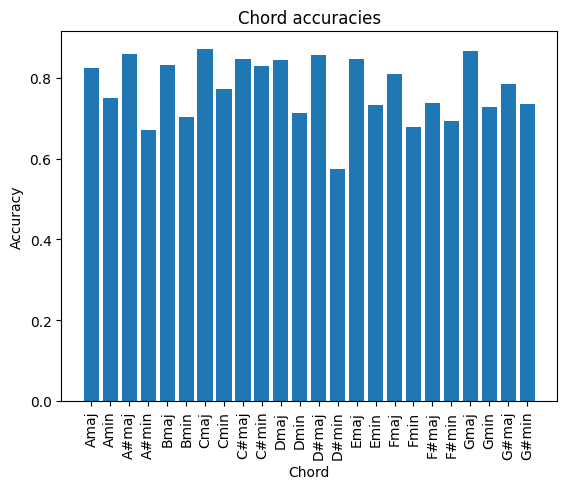

In [21]:
# Plot chord accuracies and pitch accuracies in bar chart
plt.figure()
plt.bar(range(24), chord_acc)
plt.xlabel('Chord')
plt.ylabel('Accuracy')
plt.title('Chord accuracies')
plt.xticks(np.arange(24), chord_majmin_map.values(), rotation=90)

plt.show()
